In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import random
import numpy as np

# Set seed
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

In [ ]:
pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


## **Load the dataset: en (English)**

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

Mounted at /content/drive


In [ ]:
import pandas as pd

train_df = pd.read_csv("train.tsv",  sep='\t', on_bad_lines='skip')
test_df = pd.read_csv("test.tsv",  sep='\t', on_bad_lines='skip')
print('Train dataset size:', train_df.shape)
print('Test dataset size:', test_df.shape)

Train dataset size: (33845, 6)
Test dataset size: (21832, 6)


In [ ]:
# Show the first rows
train_df.head()

,id,prompt,text,label,model,domain
0,12322,you need to stop the,you need to stop the engine and wait until it ...,generated,B,tweets
1,1682,Article 11. On the basis of the information co...,The Commission shall publish the report; an in...,generated,C,legal
2,22592,I have not been tweeting,"I have not been tweeting a lot lately, but I d...",generated,D,tweets
3,17390,NO-PROMPT,I pass my exam and really thankgod for that bu...,human,NO-MODEL,tweets
4,30453,NO-PROMPT,The template will have 3 parts: a mustache sha...,human,NO-MODEL,wiki


In [ ]:
# Since we will only focus on a binary classification, we do not need the id, prompt and model variables
# We will mantain the domain variable to later study how well the model works depending on the domain
train_df = train_df.drop(['id', 'prompt', 'model'], axis=1)
test_df = test_df.drop(['id', 'prompt', 'model'], axis=1)

In [ ]:
train_df.head()

,text,label,domain
0,you need to stop the engine and wait until it ...,generated,tweets
1,The Commission shall publish the report; an in...,generated,legal
2,"I have not been tweeting a lot lately, but I d...",generated,tweets
3,I pass my exam and really thankgod for that bu...,human,tweets
4,The template will have 3 parts: a mustache sha...,human,wiki


### Split the data

In [ ]:
X_train = train_df[['text','domain']]
y_train = train_df['label']
X_test = test_df[['text','domain']]
y_test = test_df['label']

# We will use them later
domains_train = X_train['domain']
domains_test = X_test['domain']

X_train = X_train['text']
X_test = X_test['text']

print('Training dataset size:', len(X_train))
print('Test dataset size:', len(X_test))

Training dataset size: 33845
Test dataset size: 21832


 ## **BINARY CLASSIFICATION**

## Label Encoding
Transform the labels to digit format, i.e, 0 : "human"; 1 : "generated".

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

y_train = y_train.tolist()
y_test = y_test.tolist()

le = LabelEncoder()

print("Before transforming: ", y_train[:10])
y_train = le.fit_transform(y_train)
LABELS = le.classes_
print("After transforming:", y_train[:10])

print("Before transforming: ", y_test[:10])
y_test = le.transform(y_test)
print("After transforming:", y_test[:10])

label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
print('Labels:', label2idx)

Before transforming:  ['generated', 'generated', 'generated', 'human', 'human', 'generated', 'generated', 'human', 'generated', 'generated']
After transforming: [0 0 0 1 1 0 0 1 0 0]
Before transforming:  ['human', 'human', 'generated', 'human', 'human', 'generated', 'human', 'generated', 'generated', 'human']
After transforming: [1 1 0 1 1 0 1 0 0 1]
Labels: {'generated': 0, 'human': 1}


## Preprocessing

In [ ]:
X_train = X_train.tolist()

Represent our texts into tokens using Keras. This way we can build our model with a vector of tokens.

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token = True)
# Train the tokenizer using the texts
tokenizer.fit_on_texts(X_train)

# Use index 0 represents token padding (all texts have same length)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Size of vocabulary = {}".format(NUM_WORDS))

Size of vocabulary = 45686


In [ ]:
# Transform the tokens into a sequence of integer numbers
encoded_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
print(X_train[0])
print(encoded_train[0])

you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe
[8, 84, 3, 708, 2, 1786, 5, 655, 152, 17, 5271, 9, 11, 91, 22, 166, 60, 17, 291, 23, 30, 774]


We can see from below that the texts have different lengths:

In [ ]:
length_train=[len(s) for s in encoded_train]
print(length_train)

[22, 85, 22, 20, 59, 21, 82, 78, 23, 77, 14, 84, 66, 78, 90, 77, 20, 66, 64, 21, 23, 16, 54, 86, 23, 88, 22, 89, 88, 86, 15, 29, 91, 68, 22, 23, 85, 75, 81, 22, 75, 86, 19, 90, 88, 89, 88, 34, 68, 38, 86, 20, 21, 69, 23, 58, 64, 22, 17, 45, 14, 89, 10, 61, 69, 21, 21, 72, 82, 72, 20, 57, 34, 81, 52, 68, 75, 87, 20, 79, 75, 24, 24, 73, 82, 79, 15, 22, 76, 19, 90, 18, 83, 69, 82, 19, 46, 24, 46, 97, 85, 92, 43, 17, 21, 56, 13, 91, 78, 78, 71, 72, 93, 76, 90, 74, 19, 23, 24, 16, 19, 22, 57, 44, 84, 22, 60, 83, 19, 65, 20, 64, 82, 33, 86, 84, 78, 86, 77, 19, 60, 74, 20, 78, 82, 85, 37, 88, 19, 18, 22, 19, 79, 13, 51, 73, 84, 87, 23, 39, 58, 83, 61, 69, 14, 38, 81, 82, 74, 67, 26, 54, 73, 16, 21, 67, 73, 18, 19, 73, 70, 78, 92, 64, 88, 79, 18, 73, 77, 23, 45, 80, 83, 89, 88, 25, 87, 56, 74, 81, 88, 80, 17, 61, 59, 69, 86, 90, 14, 21, 23, 23, 37, 20, 50, 57, 18, 60, 64, 16, 72, 16, 20, 67, 18, 88, 21, 21, 18, 50, 16, 75, 21, 19, 21, 72, 24, 15, 21, 24, 84, 81, 20, 18, 76, 88, 18, 20, 85, 22,

To build our BiLSTM model we need all texts to have the same length.

As we saw in the Text Size Distribution section, the mean length of the texts is 54 tokens while 75% of the texts have 81 or less tokens, and the maximum value is 98 tokens. For this reason, we will establish a optimum text size of 85 tokens.

If a text has less words than the maximum length, we will use padding.
If it has more words, we will use truncation.

In [ ]:
from keras.utils import pad_sequences
MAX_LEN=85  # 85 está bien o es muy alto???
encoded_train_pad = pad_sequences(encoded_train, maxlen = MAX_LEN,
                              padding='post', truncating='post')

In [ ]:
print(encoded_train_pad[0])
print(encoded_train[0])
print(X_train[0])

[   8   84    3  708    2 1786    5  655  152   17 5271    9   11   91
   22  166   60   17  291   23   30  774    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[8, 84, 3, 708, 2, 1786, 5, 655, 152, 17, 5271, 9, 11, 91, 22, 166, 60, 17, 291, 23, 30, 774]
you need to stop the engine and wait until it stops. This is how I would do it: // Check if its safe


## BiLSTM

### Hyperparameter Tuning

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

param_grid = dict(units1 = [64, 128, 256],
                  units2 = [32, 64, 128],
                  dropout_rate = [0.2, 0.4, 0.6],
                  learning_rate = [0.001, 0.01],
                  embedding_size = [50, 100, 200, 300])
DROPOUT = 0.4  # out of 10 neurons, 4 will be omitted

def bilstm_model(units1, units2, dropout_rate, learning_rate, embedding_size):
  model = Sequential()
  model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

  model.add(Bidirectional(LSTM(units1, return_sequences=True, recurrent_dropout=dropout_rate)))
  # Add dropout layer
  model.add(Dropout(DROPOUT))

  model.add(Bidirectional(LSTM(units2, recurrent_dropout=dropout_rate)))
  model.add(Dropout(DROPOUT))

  model.add(Dense(60, activation='relu'))

  model.add(Dense(32, activation='relu')) #50, 100, 256
  # Binary Classification
  model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
  print(model.summary())
  return model

model = KerasClassifier(build_fn=bilstm_model,
                          epochs=5, batch_size=32)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_macro',
                          cv=3, verbose=1, n_iter=5)
grid_result = grid.fit(encoded_train_pad, y_train, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')
# Evaluate testing set
test_accuracy = grid.score(encoded_test_pad, y_test)

print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

<ipython-input-17-b08fe485f0cc>:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=bilstm_model,


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 50)            2284300   
                                                                 
 bidirectional (Bidirectiona  (None, 85, 256)          183296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                              

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

param_grid = dict(units1 = [64, 128, 256],
                  units2 = [32, 64, 128],
                  dropout_rate = [0.2, 0.4, 0.6],
                  learning_rate = [0.001, 0.01],
                  embedding_size = [50, 100, 200, 300])
DROPOUT = 0.4  # out of 10 neurons, 4 will be omitted

def bilstm_model(units1, units2, dropout_rate, learning_rate, embedding_size):
  model = Sequential()
  model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

  model.add(Bidirectional(LSTM(units1, return_sequences=True, recurrent_dropout=dropout_rate)))
  # Add dropout layer
  model.add(Dropout(DROPOUT))

  model.add(Bidirectional(LSTM(units2, recurrent_dropout=dropout_rate)))
  model.add(Dropout(DROPOUT))

  model.add(Dense(60, activation='relu'))

  model.add(Dense(32, activation='relu')) #50, 100, 256
  # Binary Classification
  model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
  print(model.summary())
  return model

model = KerasClassifier(build_fn=bilstm_model,
                          epochs=5, batch_size=32)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='f1_macro',
                          cv=3, verbose=1, n_iter=5)
grid_result = grid.fit(encoded_train_pad, y_train, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')
# Evaluate testing set
test_accuracy = grid.score(encoded_test_pad, y_test)

print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


<ipython-input-17-b08fe485f0cc>:42: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=bilstm_model,


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           4568600   
                                                                 
 bidirectional (Bidirectiona  (None, 85, 128)          84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 60)                7

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 85, 100)           4568600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 85, 128)          84480     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 85, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 60)               

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 85, 100)           4568600   
                                                                 
 bidirectional_4 (Bidirectio  (None, 85, 128)          84480     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 85, 128)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 60)               

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 85, 50)            2284300   
                                                                 
 bidirectional_6 (Bidirectio  (None, 85, 256)          183296    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 85, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 60)               

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 85, 50)            2284300   
                                                                 
 bidirectional_8 (Bidirectio  (None, 85, 256)          183296    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 85, 256)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 60)               

## Best BiLSTM Model

### Build Model

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Dense, Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping

best_model = Sequential()

#### First Layer (Embeddings)

Represent each text as a matrix of vectors, where:
- Ner rows = MAX_LEN (words in a text)
- Ner columns = Ner dimensions

Resulting in a MAX_LEN x EMBEDDING_SIZE matrix.

In [ ]:
embedding_size=300
best_model.add(Embedding(NUM_WORDS, embedding_size, input_length=MAX_LEN))

#### LSTM and Dropout Layers

Add a dropout layer after each LSTM layer to regularize overfitting.

In [ ]:
from keras.layers import Bidirectional, LSTM, Dropout, Dense

DROPOUT = 0.4  # out of 10 neurons, 4 will be omitted

best_model.add(Bidirectional(LSTM(60, return_sequences=True, recurrent_dropout=0.2)))
# Add dropout layer
best_model.add(Dropout(DROPOUT))

best_model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2)))
best_model.add(Dropout(DROPOUT))

best_model.add(Dense(60, activation='relu'))

#### Dense Layer

In [ ]:
best_model.add(Dense(50, activation='relu'))
# Para clasificación binaria
best_model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

#### Compile the model

In [ ]:
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 300)           13705800  
                                                                 
 bidirectional (Bidirectiona  (None, 85, 120)          173280    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 120)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               39168     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 60)                3

### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
import time

epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

start_time = time.time()

# training
history=best_model.fit(encoded_train_pad,  # preprocessed texts
                  y_train,            # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

end_time = time.time()
print('Execution time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end_time-start_time)))

Epoch 1/5
847/847 [==============================] - 932s 1s/step - loss: 0.5057 - accuracy: 0.7427 - val_loss: 0.4281 - val_accuracy: 0.8003
Epoch 2/5
847/847 [==============================] - 875s 1s/step - loss: 0.2931 - accuracy: 0.8763 - val_loss: 0.4481 - val_accuracy: 0.7988
Epoch 3/5
847/847 [==============================] - 869s 1s/step - loss: 0.1529 - accuracy: 0.9411 - val_loss: 0.5705 - val_accuracy: 0.7713
Execution time:  00h 44m 35s


The training stops at epoch 4.

#### Save trained BiLSTM model

In [ ]:
best_model.save("BiLSTM model", include_optimizer=True)

### Learning Curves

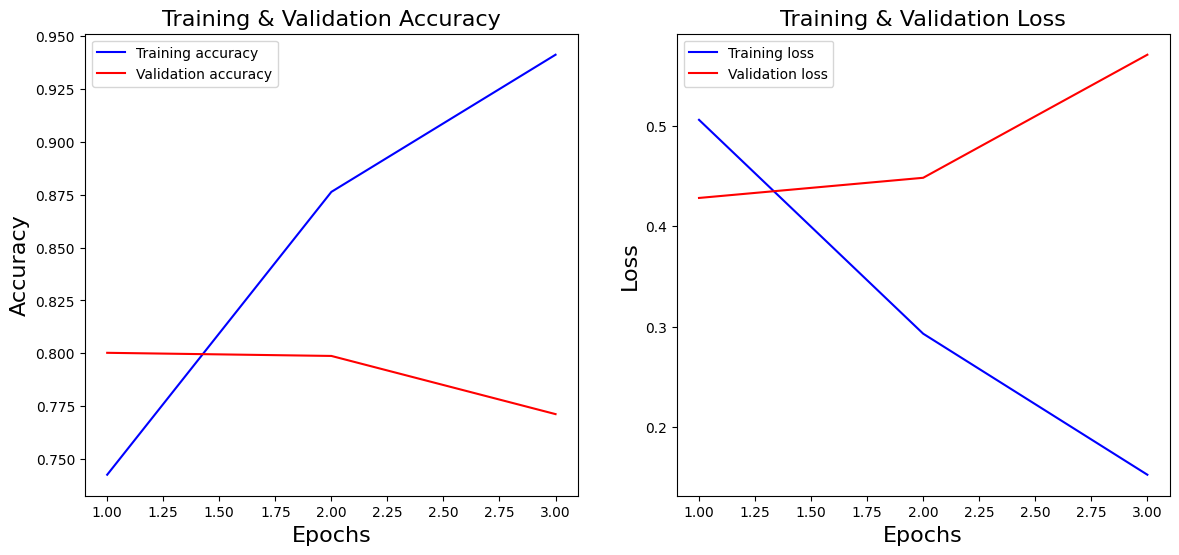

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

We observe that even though we obtain a training loss near to 0 throughout the execution of epochs, the validation loss increases.

For this reason, we need to improve and obtain a more complex model.

## (DELETE) Best BiLSTM Model with giga-wiki-100

### Build Model

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential  # add layer sequentially
from keras.layers import Dense, Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping

best_model = Sequential()

#### Load giga-wiki-100 model

In [ ]:
from gensim.models import KeyedVectors
model_we = KeyedVectors.load('wiki100.bin')   # already created when computing the best embedding

# dimension of 100
vector = model_we['trend']
# print(vector.shape)
# print(vector)

#### First Layer (Embeddings)

Represent each text as a matrix of vectors, where:
- Ner rows = MAX_LEN (words in a text)
- Ner columns = Ner dimensions

Resulting in a MAX_LEN x EMBEDDING_SIZE matrix.

In [ ]:
# Embedding size
EMBED_SIZE = vector.shape[0]
print(EMBED_SIZE)
# MATRIX: 45686 x 100
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
embedding_matrix

100


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
best_model.add(Embedding(NUM_WORDS, EMBED_SIZE,
                        input_length=MAX_LEN,
                        weights=[embedding_matrix]))

#### LSTM and Dropout Layers

Add a dropout layer after each LSTM layer to regularize overfitting.

In [ ]:
from keras.layers import Bidirectional, LSTM, Dropout, Dense

DROPOUT = 0.4  # out of 10 neurons, 4 will be omitted

best_model.add(Bidirectional(LSTM(60, return_sequences=True, recurrent_dropout=0.2)))
# Add dropout layer
best_model.add(Dropout(DROPOUT))

best_model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2)))
best_model.add(Dropout(DROPOUT))

best_model.add(Dense(60, activation='relu'))

#### Dense Layer

In [ ]:
best_model.add(Dense(50, activation='relu'))
# Para clasificación binaria
best_model.add(Dense(1, activation='sigmoid'))  # if probability near 1 returns 1, 0 otherwise

#### Compile the model

In [ ]:
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           4568600   
                                                                 
 bidirectional (Bidirectiona  (None, 85, 120)          77280     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 120)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               39168     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 60)                3

### Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# Stop the training if after 2 epochs the error does not lower
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
import time

epochs = 5  # ner cycles through the whole dataset
batch_size = 32  #16, 32 ner of samples for each step, each epoch has 33845/32 ~ 1058 steps

start_time = time.time()

# training
history=best_model.fit(encoded_train_pad,  # preprocessed texts
                  y_train,            # labels
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=[earlyStopping],
                  )

end_time = time.time()
print('Execution time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end_time-start_time)))

Epoch 1/5
847/847 [==============================] - 862s 1s/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 2/5
847/847 [==============================] - 816s 964ms/step - loss: 0.6931 - accuracy: 0.5043 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 3/5
847/847 [==============================] - 825s 974ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4999
Epoch 4/5
847/847 [==============================] - 831s 982ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5001
Epoch 5/5
847/847 [==============================] - 819s 967ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4999
Execution time:  01h 09m 31s


The training stops at epoch 4.

#### Save trained BiLSTM model

In [ ]:
best_model.save("BiLSTM w/ giga-wiki-100 model", include_optimizer=True)

### Learning Curves

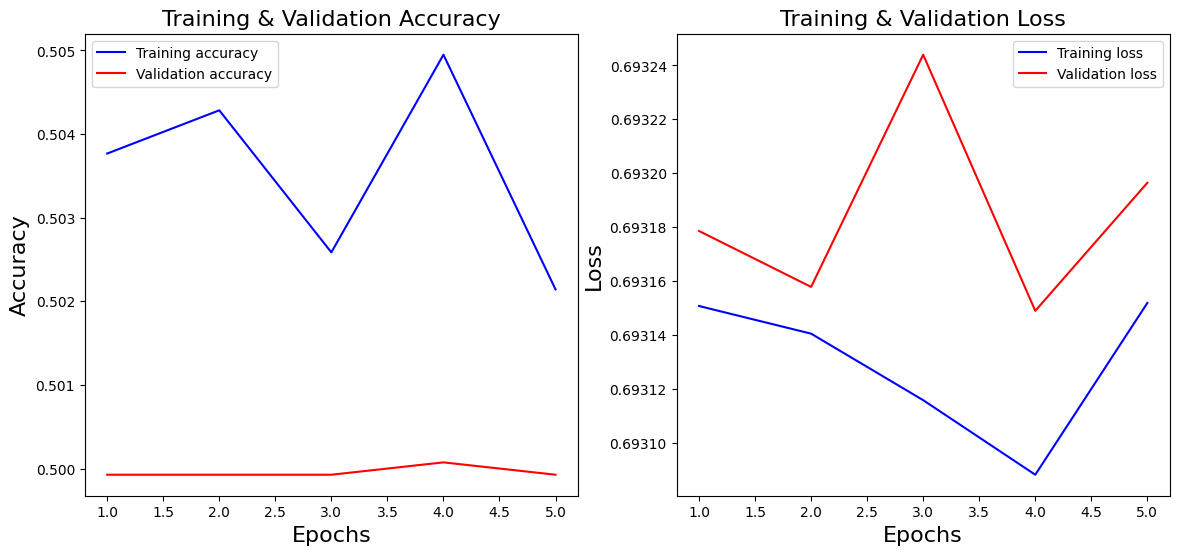

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Accuracy vs Epochs Curve
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Loss vs Epochs Curve
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

We observe that even though we obtain a training loss near to 0 throughout the execution of epochs, the validation loss increases.

For this reason, we need to improve and obtain a more complex model.

## Evaluate the model

In [ ]:
X_test = X_test.tolist()
encoded_test = tokenizer.texts_to_sequences(X_test)
encoded_test_pad = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

from sklearn.metrics import accuracy_score, classification_report

# Predict with test dataset
y_pred = np.round(best_model.predict(encoded_test_pad))

print('accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=LABELS))

683/683 [==============================] - 75s 108ms/step
accuracy: 0.6247709783803591
              precision    recall  f1-score   support

   generated       0.60      0.82      0.69     11190
       human       0.69      0.42      0.52     10642

    accuracy                           0.62     21832
   macro avg       0.64      0.62      0.61     21832
weighted avg       0.64      0.62      0.61     21832



We obtain a low accuracy of 60%.

Also, the F1-score for the generated texts is 0.7, while for the human texts is 0.41.

Overall, the macro F1-score is 0.56.

[[9191 1999]
 [6193 4449]]


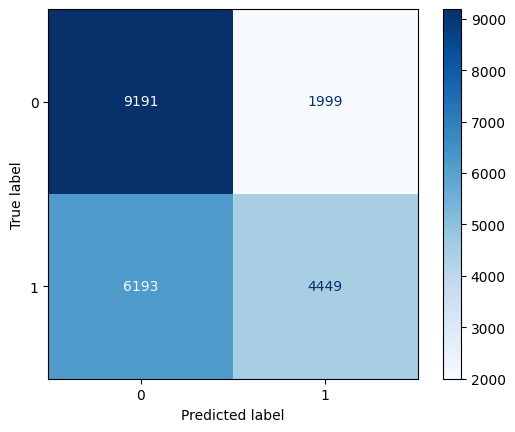

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues)

We observe that the model classifies correctly 10093 out of 11190 of the generated texts. While out of the total (10642) human texts, it classifies correctly 3052. While the remaining 7590 human texts are classified as generated, meaning our model is not the best.

Compared to the CNN model, we get worse results.

#### Evaluation for each Domain in Test dataset

We will evaluate the performance of the CNN model for each of the domains 'news' and 'reviews'.

342/342 [==============================] - 35s 102ms/step
accuracy: 0.5
              precision    recall  f1-score   support

   generated       0.00      0.00      0.00      5464
       human       0.50      1.00      0.67      5464

    accuracy                           0.50     10928
   macro avg       0.25      0.50      0.33     10928
weighted avg       0.25      0.50      0.33     10928

[[   0 5464]
 [   0 5464]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


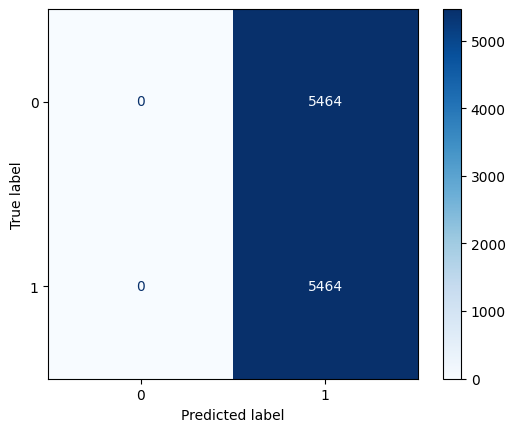

In [ ]:
X_test_news = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'news']
encoded_test_news = tokenizer.texts_to_sequences(X_test_news)
encoded_test_pad_news = pad_sequences(encoded_test_news, maxlen = MAX_LEN, padding='post')
y_test_news = y_test[domains_test=='news']

# Predict with test dataset with domain 'news'
y_pred_news = np.round(best_model.predict(encoded_test_pad_news))
print('accuracy:', accuracy_score(y_test_news, y_pred_news))
print(classification_report(y_test_news, y_pred_news, target_names=LABELS))
print(confusion_matrix(y_test_news, y_pred_news))
disp=ConfusionMatrixDisplay.from_predictions(y_test_news, y_pred_news, cmap=plt.cm.Blues)

In [ ]:
y_test_news

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
y_pred_news

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

We observe that the model categorizes incorrectly more than half of the texts written by a human in the news domain.

Moreover, the macro F1s-score is 0.53.

341/341 [==============================] - 35s 102ms/step
accuracy: 0.4748716067498166
              precision    recall  f1-score   support

   generated       0.00      0.00      0.00      5726
       human       0.47      1.00      0.64      5178

    accuracy                           0.47     10904
   macro avg       0.24      0.50      0.32     10904
weighted avg       0.23      0.47      0.31     10904

[[   0 5726]
 [   0 5178]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


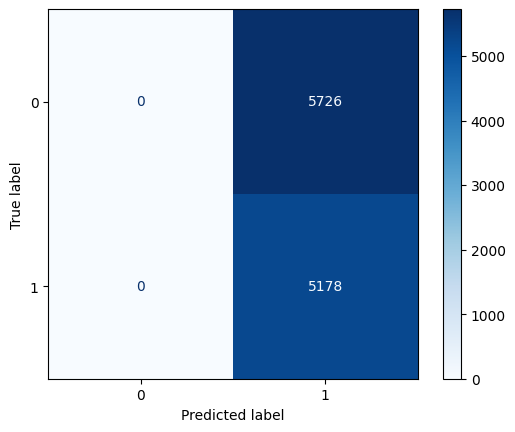

In [ ]:
X_test_reviews = [X_test[i] for i in range(len(X_test)) if domains_test[i] == 'reviews']
encoded_test_reviews = tokenizer.texts_to_sequences(X_test_reviews)
encoded_test_pad_reviews = pad_sequences(encoded_test_reviews, maxlen = MAX_LEN, padding='post')
y_test_reviews = y_test[domains_test=='reviews']

# Predict with test dataset with domain 'reviews'
y_pred_reviews = np.round(best_model.predict(encoded_test_pad_reviews))
print('accuracy:', accuracy_score(y_test_reviews, y_pred_reviews))
print(classification_report(y_test_reviews, y_pred_reviews, target_names=LABELS))
print(confusion_matrix(y_test_reviews, y_pred_reviews))
disp=ConfusionMatrixDisplay.from_predictions(y_test_reviews, y_pred_reviews, cmap=plt.cm.Blues)

For the texts written by a human in the reviews texts, we see that it does slightly worse compared to the news texts.

Moreover, the  macro F1s-score is 0.58.